In [57]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import json



In [58]:
with open('important_features.json', 'r') as file:
    features = json.load(file)[:10]
df= pd.read_csv('axis2_demo_tablepart1_0.csv')
df=df[features]

In [59]:
# 假设df是你的DataFrame，并且已经完成了预处理

# 数据缩放
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# 将数据分割为训练集和测试集
split_idx = int(len(data_scaled) * 0.8)
train_data = data_scaled[:split_idx]
test_data = data_scaled[split_idx:]

# 将numpy数组转换为torch张量
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

# 创建TensorDatasets和DataLoaders
train_dataset = TensorDataset(train_data[:, :-2], train_data[:, -2:])
test_dataset = TensorDataset(test_data[:, :-2], test_data[:, -2:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [60]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # 取序列的最后一个时间步
        return out


In [61]:
train_data.shape

torch.Size([8000, 10])

In [ ]:
# 模型参数
input_size = train_data.shape[1] - 10 # 减去目标列的数量
hidden_size = 64
output_size = 10  # 目标列的数量
num_epochs = 20
learning_rate = 0.001

# 实例化模型、损失函数和优化器
model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练循环
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# example from Internet

In [2]:

import json
import pandas as pd
with open('important_features.json', 'r') as file:
    features = json.load(file)[:10]
df= pd.read_csv('axis2_demo_tablepart1_0.csv')
df=df[features].head()
df

,Standardabweichung_y,Variance_z,Variance_y,Standardabweichung_z,Effektivwert_x,Mittlere_Absolute_Abweichung_y,Effektivwert_y,Standardabweichung_x,Mittelwert_x,Variance_x
0,163.966,220962,26911.8,469.831,657.526,117.401,571.115,328.477,569.600,108005.0
1,171.940,235057,29592.9,484.584,627.592,122.691,571.746,309.810,545.792,96078.5
2,156.322,256573,24460.9,506.277,651.770,111.817,566.507,324.498,565.248,105404.0
3,174.714,241982,30555.6,491.670,653.578,123.620,568.931,325.453,566.784,106026.0
4,162.434,268509,26411.1,517.919,661.006,128.562,586.402,339.697,567.040,115510.0


In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
from IPython.core.display import SVG
from keras.layers import LSTM, Dense, Bidirectional,GRU
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.utils import plot_model, model_to_dot
from matplotlib import ticker
from keras import regularizers
from pandas import DataFrame, concat
from sklearn import metrics
# from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
import json


In [33]:


def load_data(path):
    data_origin = pd.read_csv(path)

    with open('important_features.json', 'r') as file:
        features = json.load(file)[:10]
    #data_origin= pd.read_csv('axis2_demo_tablepart1_0.csv')
    data_origin=data_origin[features]


    # 把object类型转换为float
    data_origin = DataFrame(data_origin, dtype=float)
    # 打印显示所有列
    pd.set_option('display.max_columns', None)
    # 获得数据的描述信息
    # print(data_dropDate.describe())
    return data_origin

#单维最大最小归一化和反归一化函数
# 对于训练数据进行归一化之后。使用训练数据的最大最小值（训练数据的范围）对于测试数据进行归一化 保留周期和范围信息
def Normalize(df,low,high):
    delta = high - low
    for i in range(0,df.shape[0]):
        for j in range(0,df.shape[1]):
            df[i][j] = (df[i][j]-low[j])/delta[j]
    return df
# 定义反归一化函数
def FNormalize(df,low,high):
    delta = high - low
    for i in range(0,df.shape[0]):
        for j in range(0,df.shape[1]):
            df[i][j] = df[i][j] * delta[j] + low[j]
    return df


# 数据集转换成监督学习问题
# 数据集转换成监督学习函数
def series_to_supervise(data,n_in=1,n_out=1,dropnan=True):
    '''该函数有四个参数：

    data：作为列表或 2D NumPy 数组的观察序列。必需的。
    n_in ：作为输入 ( X )的滞后观察数。值可能在 [1..len(data)] 之间可选。默认为 1。
    n_out：作为输出的观察数（y）。值可能在 [0..len(data)-1] 之间。可选的。默认为 1。
    dropnan：布尔值是否删除具有 NaN 值的行。可选的。默认为真。
    该函数返回一个值：

    return：用于监督学习的系列 Pandas DataFrame。'''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols , names = list(),list()
    # input sequence(t-n,...,t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' %(j+1,i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# 定义一个名为split_sequences()的函数，它将采用我们定义的数据集，其中包含时间步长的行和并行序列的列，并返回输入/输出样本。
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # # find the end of this pattern
        end_ix = i + n_steps
        if end_ix > len(sequences)-n_steps:
            break
        # gather input and output parts of the pattern
        seq_x,seq_y = sequences[i:end_ix,:-1],sequences[end_ix,:-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

path ='axis2_demo_tablepart1_0.csv'
data_origin = load_data(path)
print(data_origin.shape)

# 先将数据集分成训练集和测试集
train_Standard = data_origin.iloc[:9000,:]  # （145,23）,前60行
test_Standard = data_origin.iloc[9000:,:]  # （38,23），后边

# 再转换为监督学习问题
n_in = 2
n_out = 1
train_Standard_supervise = series_to_supervise(train_Standard,n_in,n_out)  # (144,46)
test_Standard_supervise = series_to_supervise(test_Standard,n_in,n_out)  # (37,46)
print('test_Standard_supervise')
print(test_Standard_supervise.head(1))

# 将训练集和测试集分别分成输入和输出变量。最后，将输入（X）重构为 LSTM 预期的 3D 格式，即 [样本，时间步，特征]
# split into input and output
train_Standard_supervise = train_Standard_supervise.values
test_Standard_supervise = test_Standard_supervise.values
test_Standard_supervise.shape

train_X,train_y = train_Standard_supervise[:,:20],train_Standard_supervise[:,20:]
test_X,test_y = test_Standard_supervise[:,:20],test_Standard_supervise[:,20:]

#归一化
scaler = StandardScaler()
train_X=scaler.fit_transform(train_X)
train_y = train_y.reshape(train_y.shape[0],10)
train_y=scaler.fit_transform(train_y)
test_X=scaler.fit_transform(test_X)
test_y = test_y.reshape(test_y.shape[0],10)
test_y=scaler.fit_transform(test_y)
# reshape input to be 3D [samples,timeseps,features]
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))


(10000, 10)
test_Standard_supervise
      var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
9002    182.522   283201.0    33347.7      531.9    383.317    132.014   

      var7(t-2)  var8(t-2)  var9(t-2)  var10(t-2)  var1(t-1)  var2(t-1)  \
9002    337.299    345.315      166.4    119362.0    155.111   221736.0   

      var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  var8(t-1)  \
9002    24083.6    470.653    397.419    108.797    323.514    326.338   

      var9(t-1)  var10(t-1)  var1(t)   var2(t)  var3(t)  var4(t)  var5(t)  \
9002    226.816    106603.0  167.589  260984.0  28114.2   510.61  386.127   

      var6(t)  var7(t)  var8(t)  var9(t)  var10(t)  
9002  135.857  356.475  334.271   193.28  111849.0  


In [34]:
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape) 

(8998, 1, 20) (8998, 10) (998, 1, 20) (998, 10)


In [35]:
train_X.shape[1], train_X.shape[2]

(1, 20)

c:\Users\28968\.conda\envs\python_forecasting\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                    │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,310 (44.18 KB)

 Trainable params: 11,310 (44.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3927 - val_loss: 1.1324
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9738 - val_loss: 0.8458
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6388 - val_loss: 0.6278
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4087 - val_loss: 0.4830
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2831 - val_loss: 0.3964
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2002 - val_loss: 0.3452
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1679 - val_loss: 0.3125
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1540 - val_loss: 0.2926
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1534 - val_loss: 0.2828
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1484 - val_loss: 0.2805
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1367 - val_loss: 0.2785
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1487 - val_loss: 0.2758


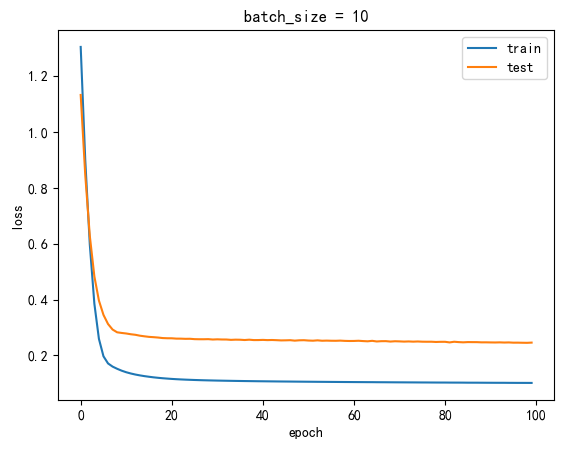

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
=============rmse==============
[ 3878563.8   3157716.2   3828501.8   3872053.    3764095.8   3719643.2
  3586103.2   3824273.2   3968034.2   4141132.    3898761.    3849794.
  3977290.8   3799194.8   3721658.2   3747522.8   3850359.5   3717623.
  3785826.5   3714405.8   3805622.    3736996.8   3747874.8   3583054.8
  3719281.8   3676964.    3613552.2   3499070.8   3794702.5   3807631.2
  3800267.    3820639.    3665007.8   3864583.8   3944320.8   3940755.5
  4010292.2   3917248.8   3947761.8   3839215.8   3977441.    3787163.5
  3652661.5   3883129.2   3478261.5   3649073.8   3374182.8   3625749.2
  3756744.    3930325.5   3869288.    3382795.    3587641.5   3764505.5
  3925192.2   3790060.    3845827.    3888141.5   3630893.8   3938918.5
  3864177.5   3837456.    3691710.    3518272.5   3784017.8   4056355.5
  3616826.2   3660618.    3811312.8   3907997.5   3852898.5   3714877.
  3449822.2   3483942.5   3557753.8   3741148.8   3972612.8   396334

In [36]:

groups = [10]
i = 1

plt.figure()
for group in groups:
    output_dim = 10  # 输出维度是10，因为我们预测未来的10个值

    # 构建模型
    model = Sequential([
        GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False),  # GRU层，50个单元
        Dense(output_dim)  # 输出层，10个单元
    ])
    # 编译模型
    model.compile(optimizer='adam', loss='mse')

    # 查看模型结构
    model.summary()
    # model = Sequential()
    # # 输入层维度：input_shape（步长，特征数）
    # model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_regularizer=regularizers.l2(0.4)))  #,return_sequences=True
    # model.add(Dense(10))
    #model.compile(loss='mae', optimizer='adam')
    # 拟合模型
    #test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    history = model.fit(train_X, train_y, epochs=100, batch_size=1000, validation_data=(test_X, test_y))

    plt.subplot(len(groups),1,i)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('batch_size = %d' %group)
    plt.legend()
    i += 1
plt.show()


# 预测测试集
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 10))
yhat=scaler.inverse_transform(yhat)
test_y=scaler.inverse_transform(test_y)
# calculate RMSE
#print(test_y)
#print(yhat)

rmse = np.sqrt(mean_squared_error(test_y, yhat))
mape = np.mean(np.abs((yhat-test_y)/test_y))*100
print('=============rmse==============')
print(rmse)
print('=============mape==============')
print(mape,'%')
print("R2 = ",metrics.r2_score(test_y, yhat)) # R2



In [46]:
test_y=pd.DataFrame(test_y)
yhat=pd.DataFrame(yhat)
with open('important_features.json', 'r') as file:
    features = json.load(file)[:10]
test_y.columns=features
yhat.columns=features
test_y.head(5)

,Standardabweichung_y,Variance_z,Variance_y,Standardabweichung_z,Effektivwert_x,Mittlere_Absolute_Abweichung_y,Effektivwert_y,Standardabweichung_x,Mittelwert_x,Variance_x
0,167.589,260984.0,28114.2,510.610,386.127,135.857,356.475,334.271,193.280,111849.0
1,158.224,227794.0,25059.8,477.039,349.513,122.982,345.553,308.732,163.840,95411.0
2,156.980,235940.0,24667.3,485.493,375.457,125.280,351.383,325.497,187.136,106054.0
3,154.823,231067.0,23994.2,480.454,365.999,116.606,335.350,316.794,183.296,100459.0
4,158.751,251365.0,25227.2,501.113,379.105,116.205,332.898,329.407,187.648,108617.0


In [51]:
test_y.iloc[:, 1][0:200]

0        260984.0
1        227794.0
2        235940.0
3        231067.0
4        251365.0
          ...    
195    22877400.0
196    27713300.0
197    21646900.0
198    26387400.0
199    23424500.0
Name: Variance_z, Length: 200, dtype: float64

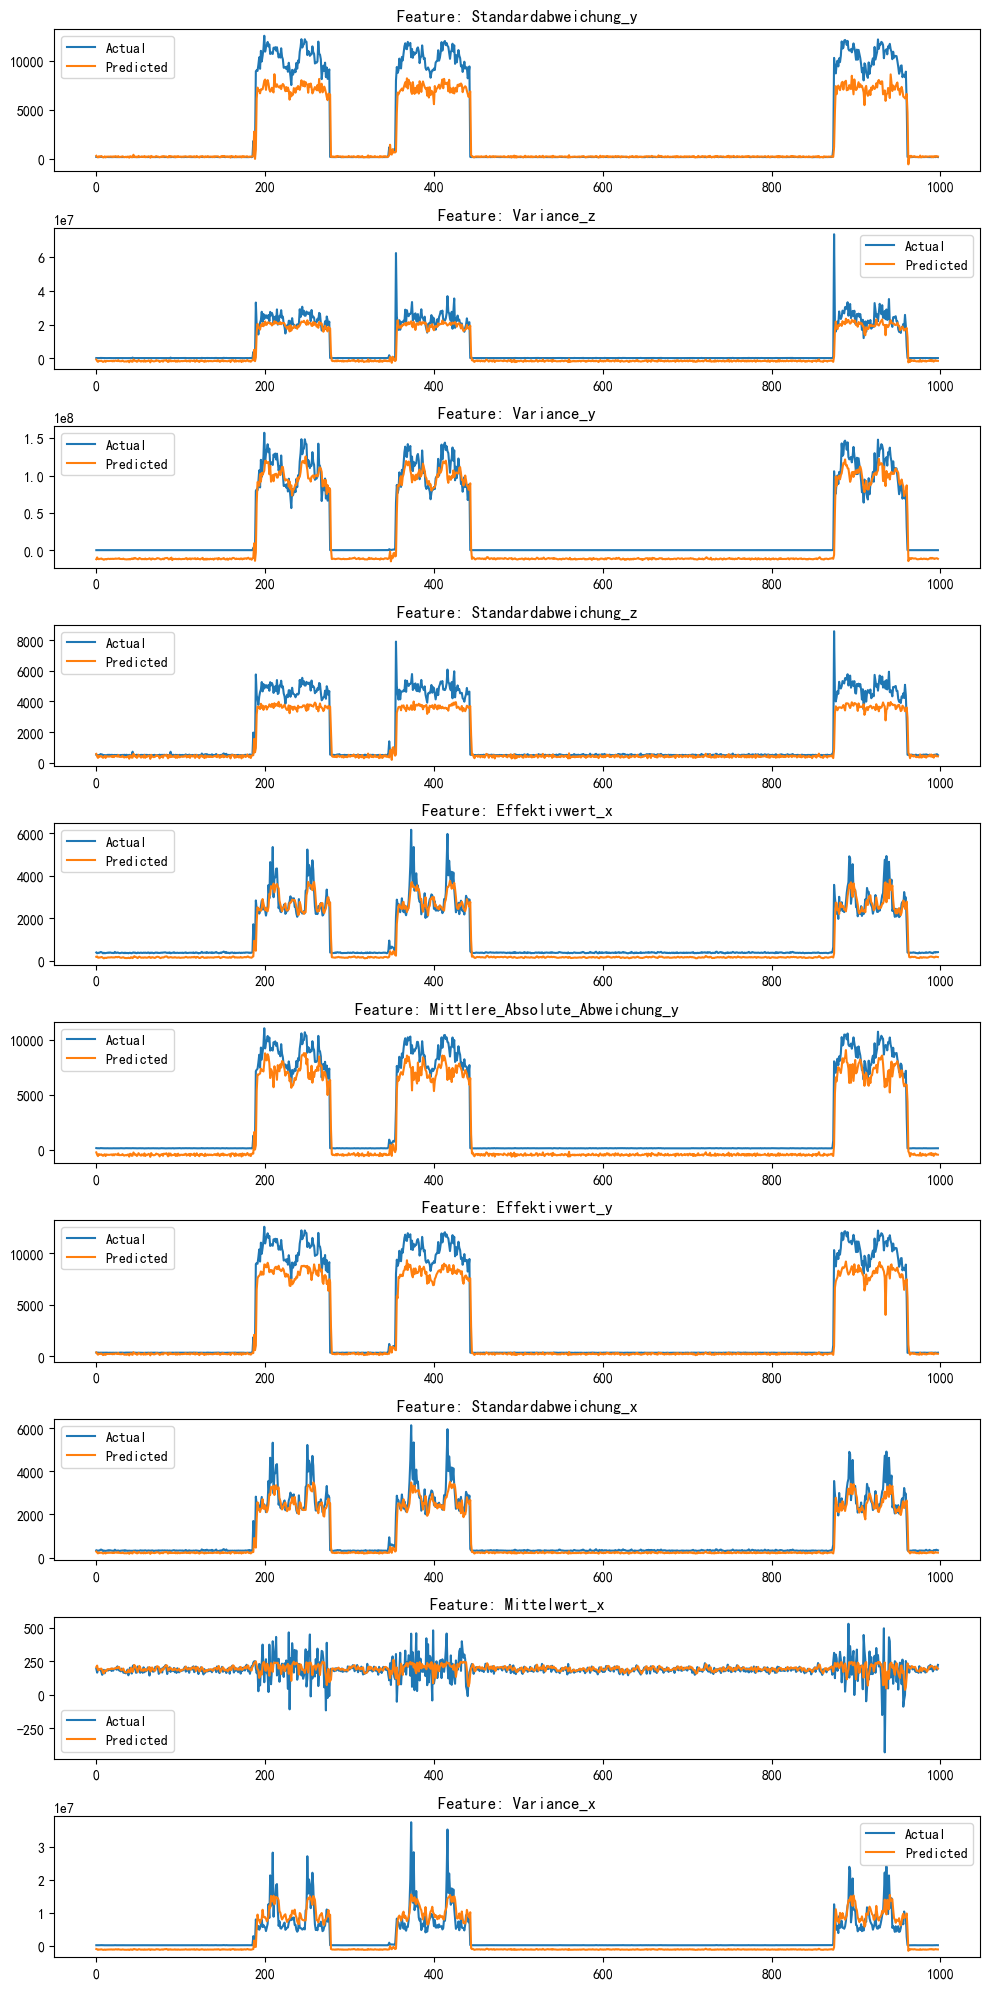

In [53]:
import matplotlib.pyplot as plt

# 创建足够的子图，每个特征一个子图，所有子图排列成一列
fig, axs = plt.subplots(len(features), 1, figsize=(10, 2*len(features)))  # 高度根据特征数量动态调整

for i in range(len(features)):
    # 如果只有一列，当只有一个特征时，axs不是列表，需要做一下处理
    ax = axs[i] if len(features) > 1 else axs
    
    ax.plot(test_y.iloc[:, i], label='Actual')
    ax.plot(yhat.iloc[:, i], label='Predicted')
    ax.set_title(f'Feature: {features[i]}')
    ax.legend()

plt.tight_layout()  #adjust the layout automatically
plt.show()

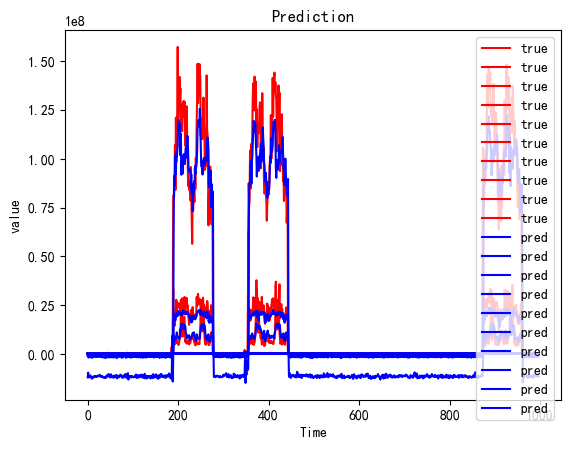

In [37]:
# 画出真实数据和预测数据的对比曲线图
plt.plot(test_y,color = 'red',label = 'true')
plt.plot(yhat,color = 'blue', label = 'pred')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('value')
plt.legend()
plt.show()

10000
Epoch [10/500], Validation Loss: 0.0590
Epoch [20/500], Validation Loss: 0.0181
Epoch [30/500], Validation Loss: 0.0143
Epoch [40/500], Validation Loss: 0.0123
Epoch [50/500], Validation Loss: 0.0108
Epoch [60/500], Validation Loss: 0.0097
Epoch [70/500], Validation Loss: 0.0087
Epoch [80/500], Validation Loss: 0.0080
Epoch [90/500], Validation Loss: 0.0076
Epoch [100/500], Validation Loss: 0.0073
Epoch [110/500], Validation Loss: 0.0071
Epoch [120/500], Validation Loss: 0.0069
Epoch [130/500], Validation Loss: 0.0068
Epoch [140/500], Validation Loss: 0.0066
Epoch [150/500], Validation Loss: 0.0065
Epoch [160/500], Validation Loss: 0.0063
Epoch [170/500], Validation Loss: 0.0062
Epoch [180/500], Validation Loss: 0.0061
Epoch [190/500], Validation Loss: 0.0060
Epoch [200/500], Validation Loss: 0.0059
Epoch [210/500], Validation Loss: 0.0058
Epoch [220/500], Validation Loss: 0.0058
Epoch [230/500], Validation Loss: 0.0057
Epoch [240/500], Validation Loss: 0.0057
Epoch [250/500], Va

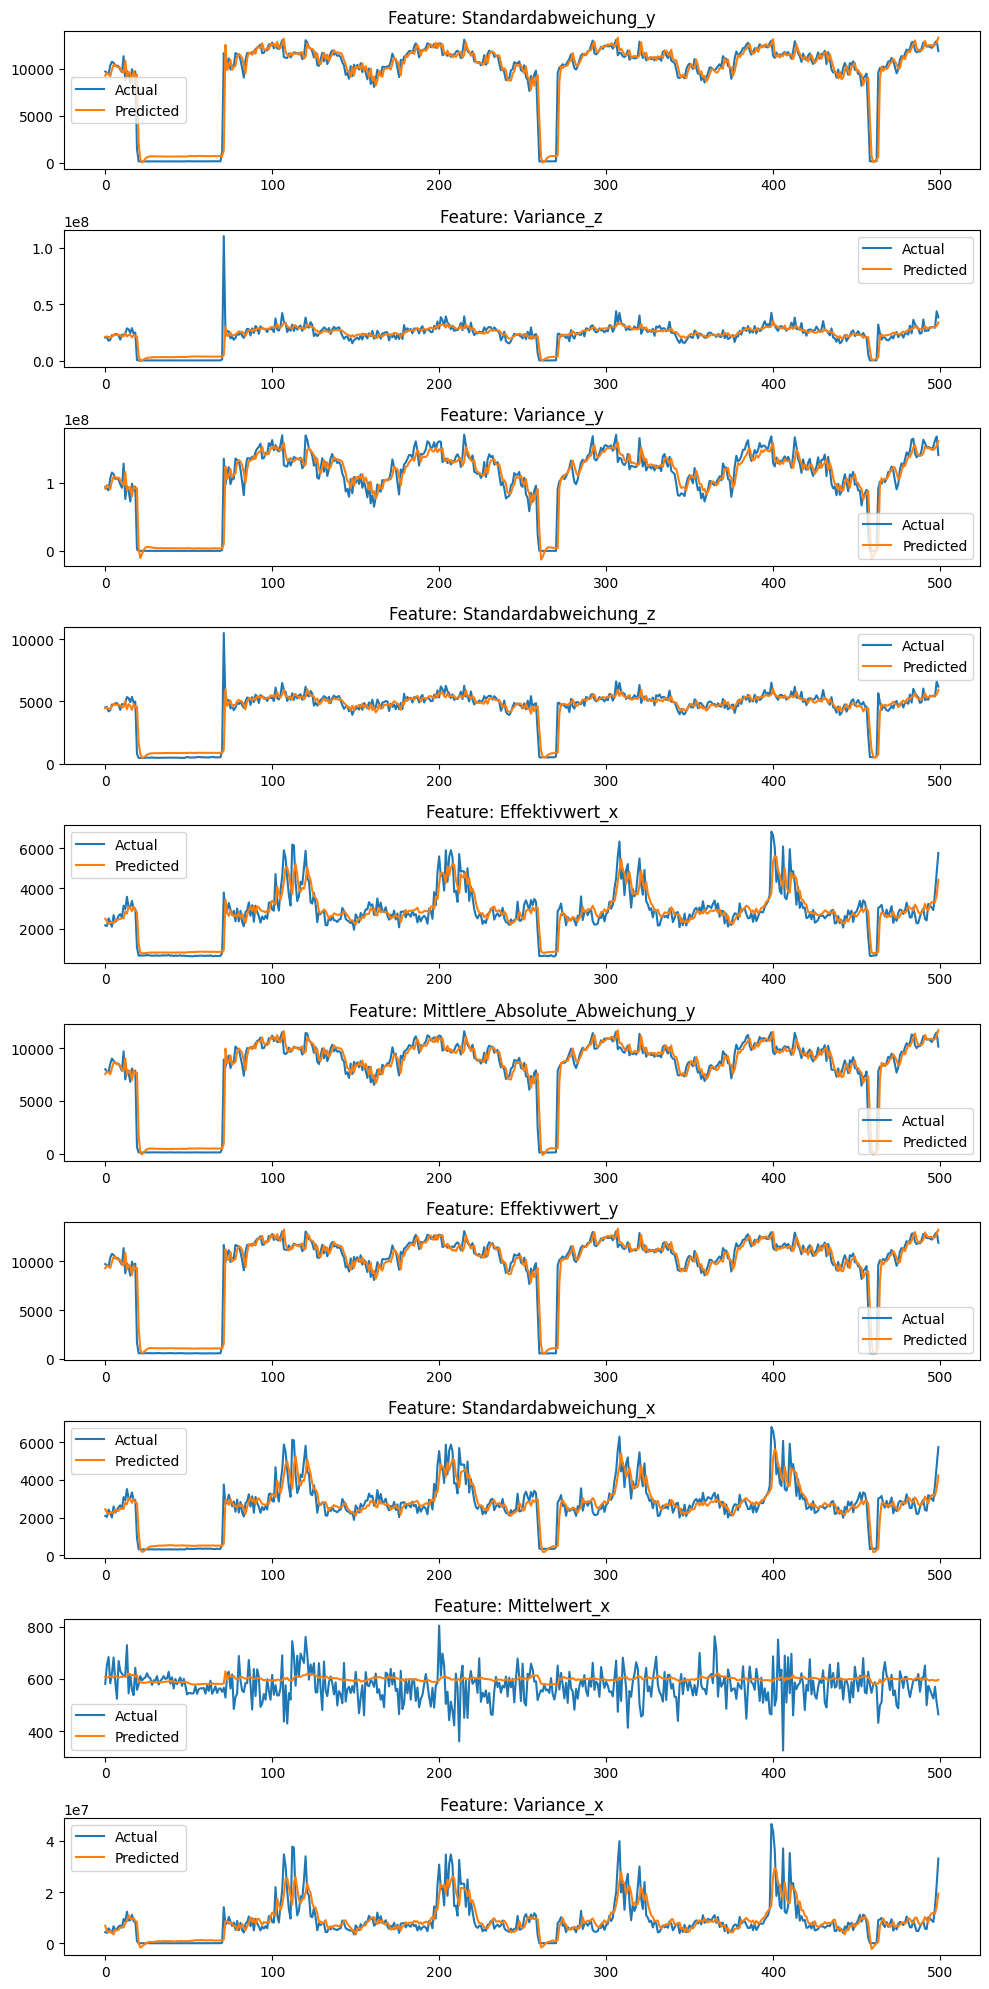

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import os

# 加载数据

all_data=pd.read_csv("axis2_demo_tablepart1_0.csv")

print(len(all_data))
# Assuming 'important_features.json' contains a JSON array of feature names
import json

with open('important_features.json', 'r') as file:
    features = json.load(file)[:10]

data_selected = all_data[features][:5000]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_selected)

# 准备数据集
def create_dataset(dataset, look_back=50):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]  # 从当前索引开始，取后50个数据作为输入
        X.append(a)
        b = dataset[i + look_back, :]      # 第51个数据作为输出
        Y.append(b)
    return np.array(X), np.array(Y)


look_back = 2500
X, Y = create_dataset(data_scaled, look_back)

# 划分数据集
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
Y_train, Y_test = Y[:int(0.8 * len(Y))], Y[int(0.8 * len(Y)):]


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Create DataLoader instances
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        _, hn = self.gru(x)  # GRU只返回hidden state, 没有cell state
        out = self.fc(hn[-1])
        return out



model = GRUModel(len(features), 50, len(features))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, patience=20):
    # patience参数是我们愿意等待验证损失改善的epoch数量
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # 在验证集上评估模型
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(validation_loader)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        # 检查验证损失是否改善
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break  # 提前停止


train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=500, patience=20)

# 进行预测
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = []
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())

predicted = np.vstack(predictions)  # Stack arrays in sequence vertically

# 反归一化以获取实际预测值
predicted_actual = scaler.inverse_transform(predicted)

# plot and compare the actual and predicted values for each feature
torch.save(model.state_dict(), 'lstmb_atch_model.pth')

# print the actual and predicted values for each feature
import matplotlib.pyplot as plt

true_test = scaler.inverse_transform(Y_test)
# 创建足够的子图，每个特征一个子图，所有子图排列成一列
fig, axs = plt.subplots(len(features), 1, figsize=(10, 2*len(features)))  # 高度根据特征数量动态调整

for i in range(len(features)):
    # 如果只有一列，当只有一个特征时，axs不是列表，需要做一下处理
    ax = axs[i] if len(features) > 1 else axs
    
    ax.plot(true_test[:, i], label='Actual')
    ax.plot(predicted_actual[:, i], label='Predicted')
    ax.set_title(f'Feature: {features[i]}')
    ax.legend()

plt.tight_layout()  # #adjust the parameter automatically and full fill the layout
plt.show()


In [2]:
for x, y in test_loader:
    print(x.shape, y.shape)
# print the first value in test_loader
#print(x[0].shape)
initial_input = x[0].unsqueeze(0)
print(initial_input.shape)
frist_predict=model(initial_input)
frist_predict.unsqueeze(1).shape
frist_predict

torch.Size([500, 2500, 10]) torch.Size([500, 10])
torch.Size([1, 2500, 10])


tensor([[0.6723, 0.1742, 0.4873, 0.3805, 0.2071, 0.6306, 0.6614, 0.2317, 0.4059,
         0.0737]], grad_fn=<AddmmBackward0>)

(500, 10)
[ 9698.89993254  9570.90989728  9443.40964455 10344.10031893
 10737.60017026 10634.99962078 10288.00001375 10337.10030822
 10240.90006872  9891.28020599  9632.05027482 11328.99964305
  8734.24010364  9767.95037876  9429.37002026  8520.07986386
  9942.19980817  9410.91022988  9717.30961316  1500.03000077]
[9262.751  9226.632  9192.472  9126.0625 9038.415  8945.534  8847.663
 8745.563  8639.592  8529.993  8416.897  8300.349  8180.3105 8056.6865
 7929.3345 7798.074  7662.699  7522.9917 7378.729  7229.7   ]


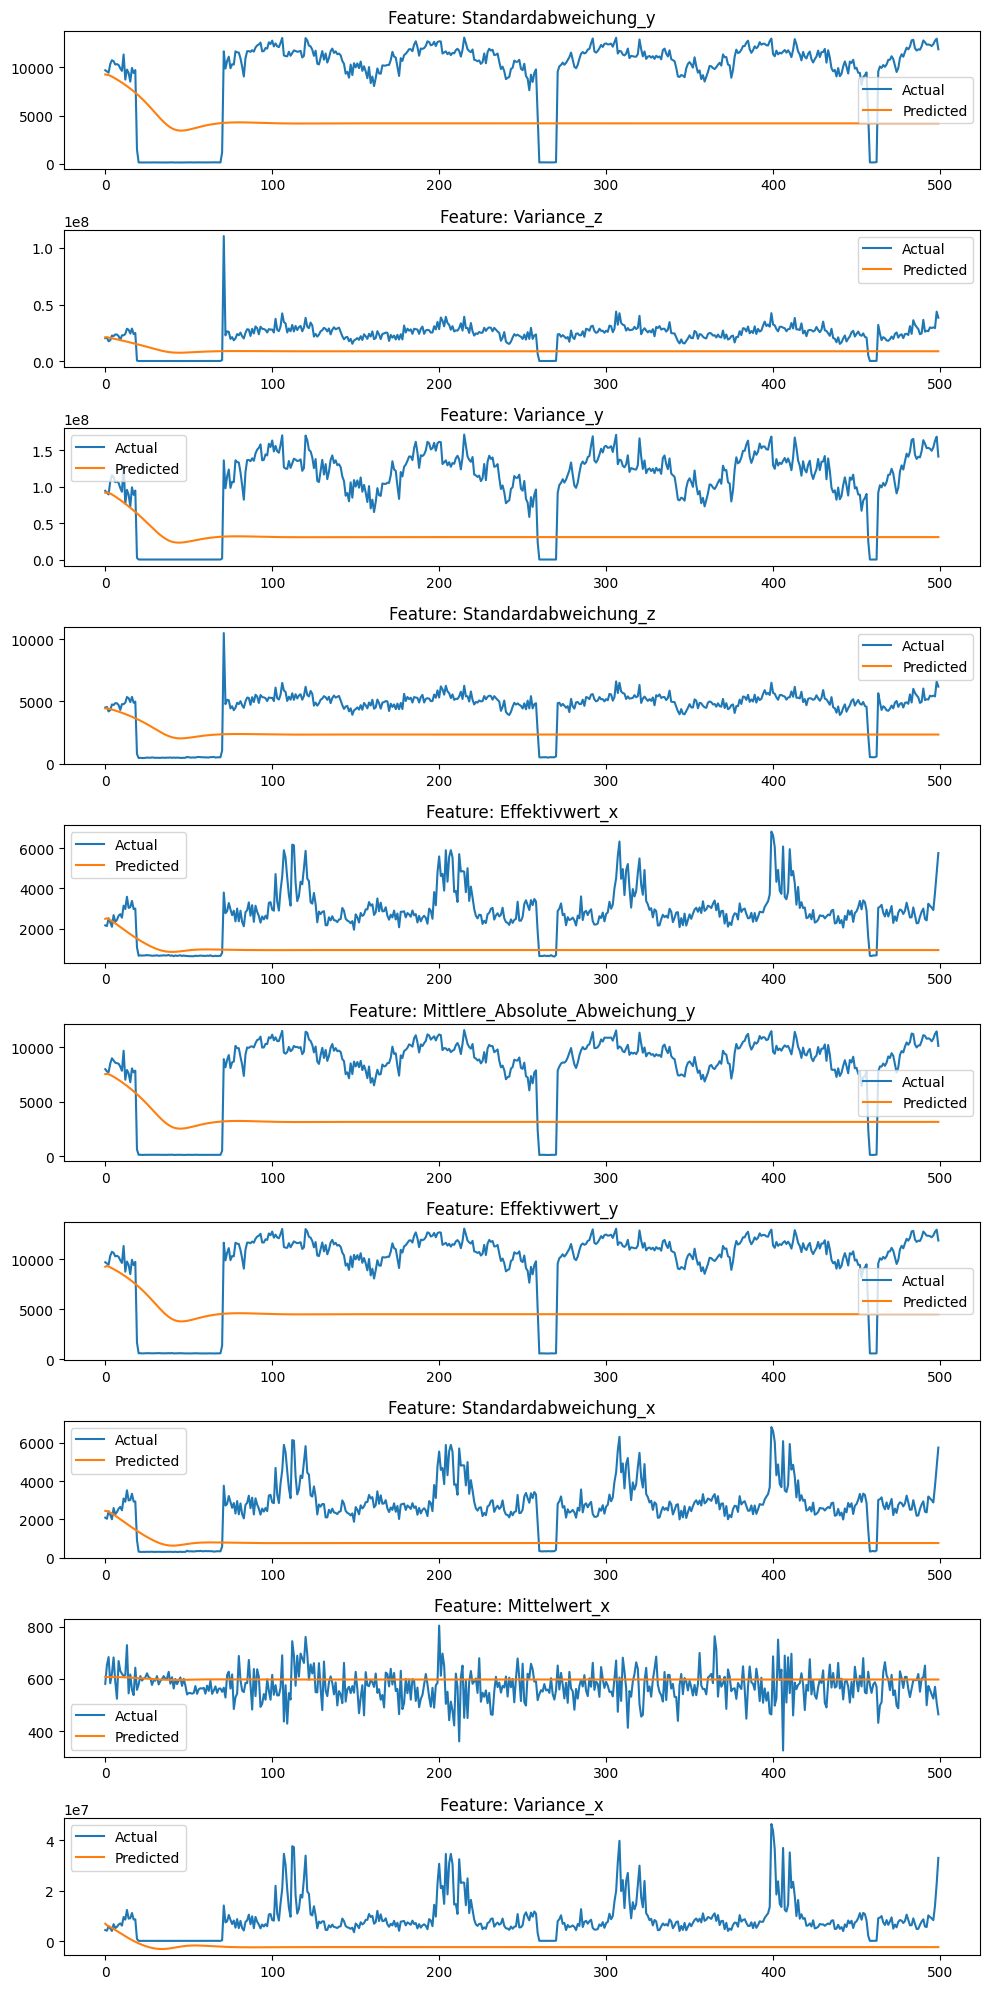

In [3]:
import torch

# 假设已经有了模型和数据
# model - 已训练的PyTorch模型
# initial_window - 初始的输入窗口，形状为 [1, window_size, feature_dim]
# n_predictions - 需要生成的预测数量

def recursive_prediction(model, initial_window, n_predictions):
    model.eval()
    current_window = initial_window
    predictions = []

    for _ in range(n_predictions):
        # 使用当前窗口进行预测
        with torch.no_grad():
            current_prediction = model(current_window)  # 假设输出形状为 [1, 1, feature_dim]
        
        # 记录预测结果
        predictions.append(current_prediction.numpy().flatten())

        # 更新窗口：移除第一个元素，添加新的预测值
        current_window = torch.cat((current_window[:, 1:, :], current_prediction.unsqueeze(1)), dim=1)
    
    return predictions

# 初始窗口设置
# 假设窗口大小为50，特征维度为10
initial_window = initial_input  # 这里使用随机数据代替真实的初始窗口
n_predictions = 500 # 预测未来100个时间步

# 调用递归预测函数
predicted_values = recursive_prediction(model, initial_window, n_predictions)

# 打印或处理预测结果
predicted_values = np.array(predicted_values)
print(predicted_values.shape)  # 输出形状应为 [n_predictions, feature_dim]
predicted_new = scaler.inverse_transform(predicted_values)

# plot and compare the actual and predicted values for each feature
#torch.save(model.state_dict(), 'lstmb_atch_model.pth')

# print the actual and predicted values for each feature
import matplotlib.pyplot as plt

true_test = scaler.inverse_transform(Y_test)
print(true_test[:20,0])
print(predicted_new[:20,0])
# 创建足够的子图，每个特征一个子图，所有子图排列成一列
fig, axs = plt.subplots(len(features), 1, figsize=(10, 2*len(features)))  # 高度根据特征数量动态调整

for i in range(len(features)):
    # 如果只有一列，当只有一个特征时，axs不是列表，需要做一下处理
    ax = axs[i] if len(features) > 1 else axs
    
    ax.plot(true_test[:, i], label='Actual')
    ax.plot(predicted_new[:, i], label='Predicted')
    ax.set_title(f'Feature: {features[i]}')
    ax.legend()

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()
